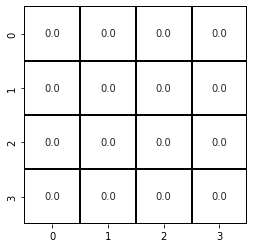

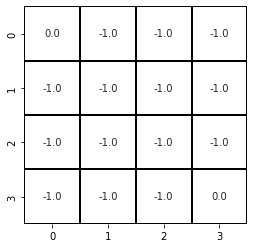

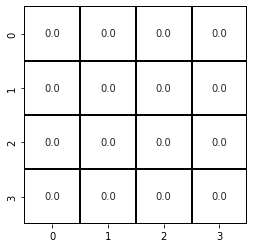

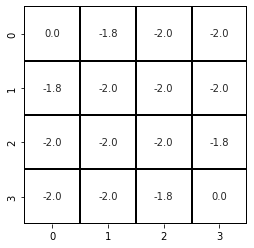

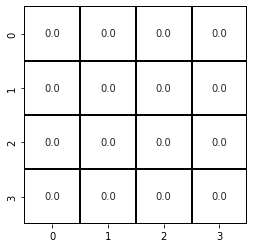

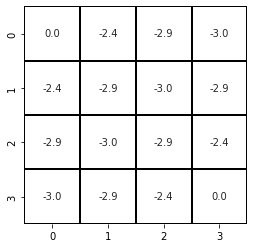

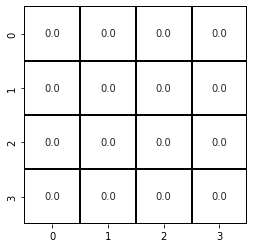

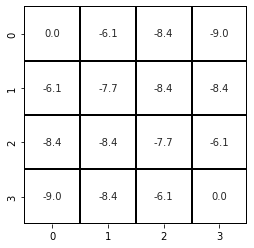

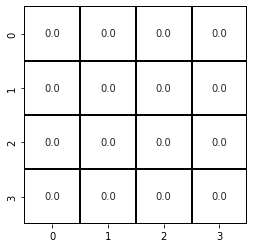

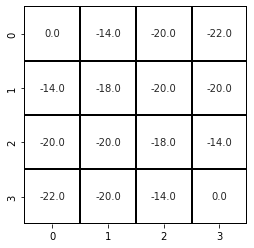

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap

W = LinearSegmentedColormap.from_list('w', ["w", "w"], N=256)

ACTIONS = {
    0: [1, 0],   # north
    1: [-1, 0],  # south
    2: [0, -1],  # west
    3: [0, 1],   # east
}


class GridWorld:
    def __init__(self, size=4):
        """
        A gridworld environment with absorbing states at [0, 0] and [size - 1, size - 1].
        Args:
            size (int): the dimension of the grid in each direction
            cell_reward (float): the reward return after extiting any non absorbing state
        """
        self.state_value = np.zeros((size, size))
        return

    def reset(self):
        self.state_value = np.zeros((size, size))
        return

    def step(self, state, action):
        # is terminal state?
        size = len(self.state_value) - 1
        if (state == (0, 0)) or (state == (size, size)):
            return state, 0

        s_1 = (state[0] + action[0], state[1] + action[1])
        reward = -1
        # out of bounds north-south
        if s_1[0] < 0 or s_1[0] >= len(self.state_value):
            s_1 = state
        # out of bounds east-west
        elif s_1[1] < 0 or s_1[1] >= len(self.state_value):
            s_1 = state

        return s_1, reward

    def render(self, title=None):
        """
        Displays the current value table of mini gridworld environment
        """
        size = len(self.state_value) if len(self.state_value) < 20 else 20
        fig, ax = plt.subplots(figsize=(size, size))
        if title is not None:
            ax.set_title(title)
        ax.grid(which='major', axis='both',
                linestyle='-', color='k', linewidth=2)
        sn.heatmap(self.state_value, annot=True, fmt=".1f", cmap=W,
                   linewidths=1, linecolor="black", cbar=False)
        plt.show()
        return fig, ax

    def bellman_expectation(self, state, probs, discount):
        """
        Makes a one step lookahead and applies the bellman expectation equation to the state self.state_value[state]
        Args:
            state (Tuple[int, int]): the x, y indices that define the address on the value table
            probs (List[float]): transition probabilities for each action
            in_place (bool): if False, the value table is updated after all the new values have been calculated.
                             if True the state [i, j] will new already new values for the states [< i, < j]
        Returns:
            (numpy.ndarrray): the new value for the specified state
        """
        # absorbing state
        value = 0
        for c, action in ACTIONS.items():
            s_1, reward = self.step(state, action)
            value += probs[c] * (reward + discount * self.state_value[s_1])
        return value


def policy_evaluation(env, policy=None, steps=1, discount=1., in_place=False):
    """
    Args:
        policy (numpy.array): a numpy 3-D numpy array, where the first two dimensions identify a state and the third dimension identifies the actions.
                              The array stores the probability of taking each action.
        steps (int): the number of iterations of the algorithm
        discount (float): discount factor for the bellman equations
        in_place (bool): if False, the value table is updated after all the new values have been calculated.
             if True the state [i, j] will new already new values for the states [< i, < j]
    """
    if policy is None:
        # uniform random policy
        policy = np.ones((*env.state_value.shape, len(ACTIONS))) * 0.25

    for k in range(steps):
        # cache old values if not in place
        values = env.state_value if in_place else np.empty_like(
            env.state_value)
        for i in range(len(env.state_value)):
            for j in range(len(env.state_value[i])):
                # apply bellman expectation equation to each state
                state = (i, j)
                value = env.bellman_expectation(state, policy[i, j], discount)
                values[i, j] = value * discount
        # set the new value table
        env.state_value = values
    return env.state_value


if __name__ == "__main__":
    # reprocuce Figure 4.1
    for k in [1, 2, 3, 10, 1000]:
        env = GridWorld(4)
        env.render()
        value_table = policy_evaluation(env, steps=k, in_place=False)
        env.render()

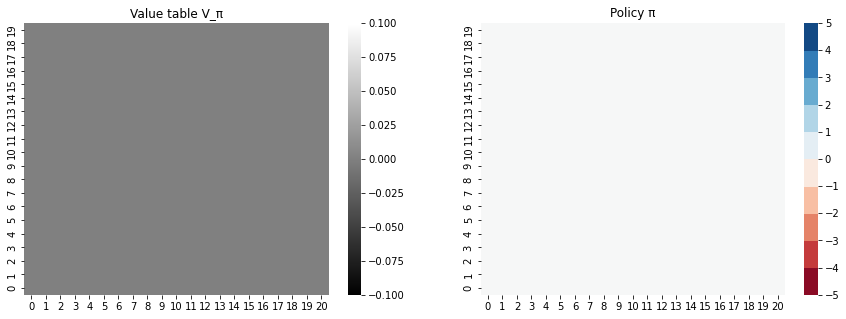

Iterating through policy 1
	Evaluating policy 1
		Value delta 0.00094		 
	Improving policy 1


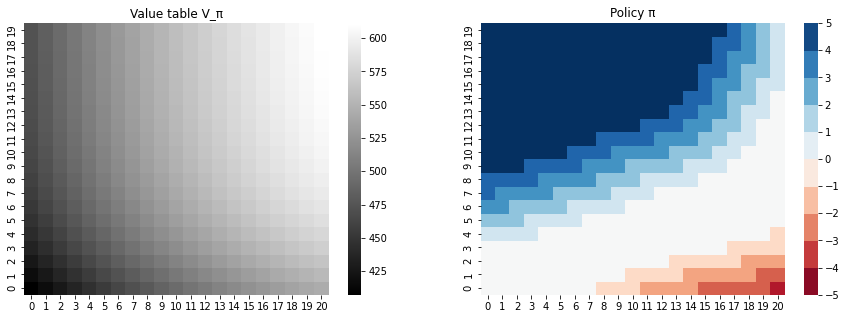

Iterating through policy 2
	Evaluating policy 2
		Value delta 0.00090		 
	Improving policy 2


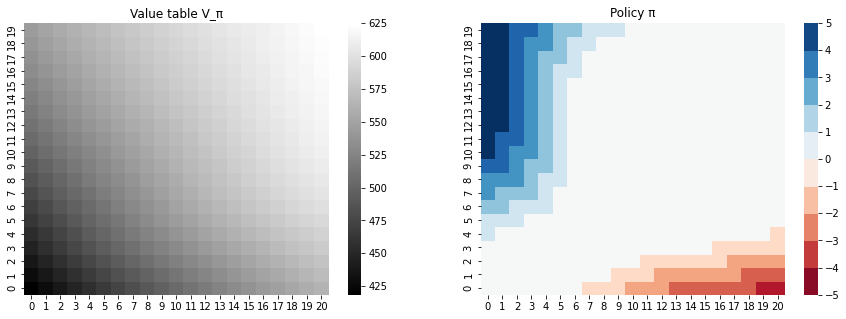

Iterating through policy 3
	Evaluating policy 3
		Value delta 0.00096		 
	Improving policy 3


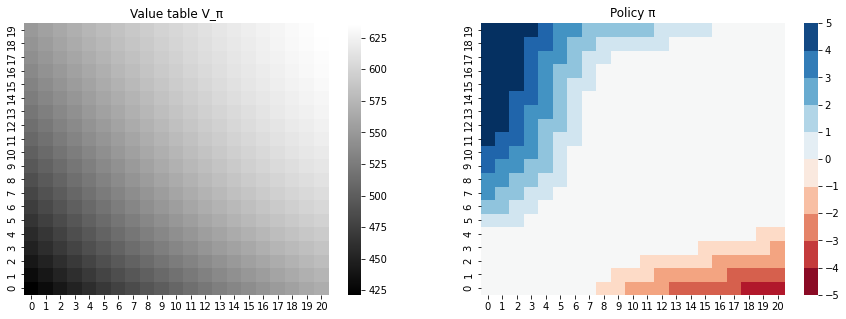

Iterating through policy 4
	Evaluating policy 4
		Value delta 0.00095		 
	Improving policy 4


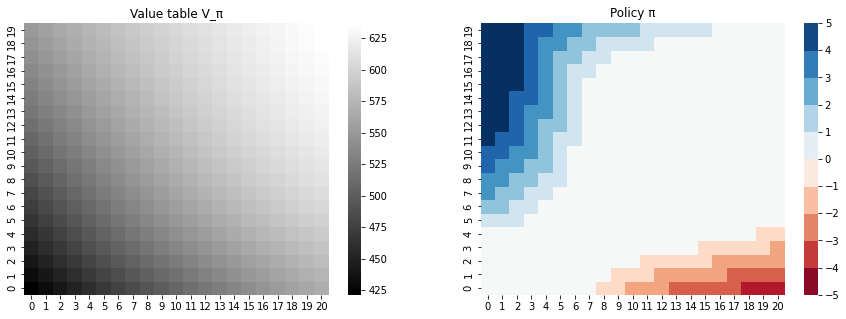

Iterating through policy 5
	Evaluating policy 5
		Value delta 0.00095		 
	Improving policy 5
Policy is stable. π converged to π*


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math


ACTIONS = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
CAR_RENTAL_COST = 10
CAR_MOVE_COST = 2
MAX_CARS = 20
MAX_MOVE = 5
REQUEST_1_LAMBDA = 3
DROPOFF_1_LAMBDA = 3
REQUEST_2_LAMBDA = 4
DROPOFF_B_LAMBDA = 2
DISCOUNT = 0.9


class CarRental:
    def __init__(self):
        self.reset()
        return

    def step(self, state, action):
        """
        Run one timestep of the environment's dynamics.
        Args:
            state (Tuple[int, int]): A tuple storing the number of available locations, respectively at A and B
            action (int): The number of cars to be moved
        Returns:
            (Tuple[Tuple[int, int], float]): The new state of the system, and its correspondent reward
        """
        morning_n1 = int(state[0] - action)
        morning_n2 = int(state[1] + action)
        new_state = (morning_n1, morning_n2)
        reward = self.get_reward(new_state)
        return new_state, reward

    def reset(self):
        """
        Resets the state of the environment and returns an initial observation.
        """
        self._poisson_prob = {}
        self.state_values = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
        self.policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), np.int32)
        self._probs_1, self._rewards_1 = self.precompute_model(
            REQUEST_1_LAMBDA, DROPOFF_1_LAMBDA)
        self._probs_2, self._rewards_2 = self.precompute_model(
            REQUEST_2_LAMBDA, DROPOFF_B_LAMBDA)
        return

    def render(self):
        """
        Plots the current value table and the current policy
        """
        # plot value table
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        sns.heatmap(self.state_values, cmap="gray", ax=ax[0])
        ax[0].set_ylim(0, MAX_CARS)
        ax[0].set_title("Value table V_π")
        # plot policy
        cmaplist = [plt.cm.RdBu(i) for i in range(plt.cm.RdBu.N)]
        dRbBu = matplotlib.colors.LinearSegmentedColormap.from_list(
            'dRdBu', cmaplist, plt.cm.RdBu.N)
        sns.heatmap(self.policy, vmin=-5, vmax=5, cmap=dRbBu,
                    ax=ax[1], cbar_kws={"ticks": ACTIONS, "boundaries": ACTIONS})
        ax[1].set_ylim(0, MAX_CARS)
        ax[1].set_title("Policy π")
        plt.show()
        return fig, ax

    def get_transition_probability(self, state, new_state):
        """
        Args:
            state (Tuple[int, int]): A tuple storing the number of available locations, respectively at A and B
            new_state (Tuple[int, int]): A possible future state of the environment
        Returns:
            (float): The probability that the system transitions from a state `s` to a state `s'`.
        """
        return self._probs_1[(state[0], new_state[0])] * self._probs_2[(state[1], new_state[1])]

    def get_reward(self, state):
        """
        Computes the reward for the given state.
        Args:
            state (Tuple[int, int]): A tuple storing the number of available locations, respectively at A and B
        Returns:
            (float): The expected reward for the given state
        """
        return self._rewards_1[state[0]] + self._rewards_2[state[1]]

    def get_valid_action(self, state, action):
        """
        Return an action that is compatible with the current state of the system.
        For example, if there are 2 cars available at location 1, and the action is to move 3 cars from location 1,
        the function will clip the value at 2.
        Args:
            state (Tuple[int, int]): A tuple storing the number of available locations, respectively at A and B
            action (int): The number of cars to be moved
        Returns:
            (int): a feasible number of cars to be moved
        """
        cars_at_1, cars_at_2 = state
        # Jack can't move more cars than he has available
        action = max(-cars_at_2, min(action, cars_at_1))
        # Jack can move at most 5 cars
        action = max(-MAX_MOVE, min(MAX_MOVE, action))
        return action

    def get_available_actions(self, state):
        """
        Return the list of actions compatible with the current state of the system.
        Args:
            state (Tuple[int, int]): A tuple storing the number of available locations, respectively at A and B
        Returns:
            (List[int]): The list of actions compatible with the current state of the system.
        """
        return list(range(max(-MAX_CARS, - state[1]), min(MAX_CARS, state[0]) + 1))

    def poisson_probability(self, n, lam):
        """
        Computes the probability that the number drawn from a poisson distribution is `n`, given a lamdda of `lam`.
        `$p = e^(-λ) * (λ^n / n!)$
        Args:
            n (int): the number expected to be drawn from the distribution
            lam (int): the λ parameter of the poisson distribution
        Returns:
            (float): the probability that the number is `n`
        """
        key = (n, lam)
        if key not in self._poisson_prob:
            self._poisson_prob[key] = math.exp(-lam) * \
                (math.pow(lam, n) / math.factorial(n))
        return self._poisson_prob[key]

    def precompute_model(self, lambda_requests, lambda_dropoffs):
        """
        Precomputes the model dynamics for efficiency: the reward and the transition probabilities.
        Calculates the expected rewards for a range of requests from 0 to MAX_CARS + max(ACTIONS) + 1, and stores them into a privare array.
        Calculates the probability that the system transitions from a state `s` to a state `s'`.
        Args:
            lambda_requests (int): the λ parameter of the poisson distribution that describes the requests
            lambda_dropoffs (int): the λ parameter of the poisson distribution that describes the dropoffs
        Returns:
            (Tuple[numpy.ndarray, numpy.ndarray]): The array of system transitions probabilities and the array of expected rewards
        """
        P, R = {}, {}
        requests = 0
        for requests in range(MAX_CARS + max(ACTIONS) + 1):
            request_prob = self.poisson_probability(requests, lambda_requests)
            for n in range(MAX_CARS + max(ACTIONS) + 1):
                if n not in R:
                    R[n] = 0.
                R[n] += CAR_RENTAL_COST * request_prob * min(requests, n)
            dropoffs = 0
            for dropoffs in range(MAX_CARS + max(ACTIONS) + 1):
                dropoffs_prob = self.poisson_probability(
                    dropoffs, lambda_dropoffs)
                for n in range(MAX_CARS + max(ACTIONS) + 1):
                    satisfied_requests = min(requests, n)
                    new_n = max(
                        0, min(MAX_CARS, n + dropoffs - satisfied_requests))
                    if (n, new_n) not in P:
                        P[(n, new_n)] = 0.
                    P[(n, new_n)] += request_prob * dropoffs_prob
        return P, R

    def bellman_expectation(self, state, action):
        """
        Solves the bellman expectation equation for given state
        V(s) = p(s, r | s' π(s)) * (R(s) + γ * V(s'))
        Args:
            state (Tuple[int, int]): a tuple storing the number of available locations, respectively at A and B
            action (int): The number of cars to be moved
        Returns:
            (float): the value V(s) of the current state pair
        """
        action = self.get_valid_action(state, action)
        (morning_n1, morning_n2), r = self.step(state, action)

        state_value = -CAR_MOVE_COST * abs(action)
        for new_n1 in range(MAX_CARS + 1):
            for new_n2 in range(MAX_CARS + 1):
                p = self.get_transition_probability(
                    (morning_n1, morning_n2), (new_n1, new_n2))
                state_value += p * \
                    (r + DISCOUNT * self.state_values[new_n1, new_n2])
        return state_value

    def policy_evaluation(self, theta=1e-3):
        """
        Computes the true value table for the current policy using iterative policy evaluation.
        At the end of the process it updates the state-value table with the newly computed value function.
        Returns:
            (numpy.ndarray): The value function of the current policy stored as a 2D array
        """
        new_values = np.empty_like(self.state_values)
        while True:
            # for each state s ∈ S
            for available_A in range(MAX_CARS + 1):
                for available_B in range(MAX_CARS + 1):
                    state = (available_A, available_B)
                    # a = π(s)
                    action = self.policy[available_A, available_B]
                    # V(s) = p(s, r | s' π(s)) * (R(s) + γ * V(s'))
                    new_state_value = self.bellman_expectation(state, action)
                    # according the the original lisp code, the evaluation is performed asynchronously:
                    # http://incompleteideas.net/book/code/jacks.lisp
                    new_values[state] = new_state_value
            delta = np.max(np.abs(self.state_values - new_values))
            print("\t\tValue delta {:.5f}\t\t ".format(delta), end="\r")
            self.state_values = new_values.copy()
            new_values = np.empty_like(self.state_values)
            if delta < theta:
                print()
                return

        raise ValueError(
            "The value table did not converge. Check your inputs or look for bugs.")

    def policy_improvement(self):
        """
        Makes one step of policy improvement following a greedy policy.
        For each state of the model, it iterates through all the feasible actions and finds the greediest one.
        The current policy is updated synchronously for each state, i.e. only after all the states have been visited.
        Returns:
            (bool): True if the policy has not improved
        """
        new_policy = np.empty_like(self.policy)
        # for each state s ∈ S
        for available_A in range(MAX_CARS + 1):
            for available_B in range(MAX_CARS + 1):
                state = (available_A, available_B)
                best_action = self.policy[state]
                best_value = -float("inf")
                for action in self.get_available_actions(state):
                    value = self.bellman_expectation(state, action)
#                     print(state, action, value)
                    if value > best_value:
                        best_value = value
                        best_action = action
                new_policy[available_A, available_B] = best_action
        converged = (new_policy == self.policy).all()
        self.policy = new_policy.copy()
        return converged

    def policy_iteration(self, plot=False):
        """
        Computes the optimal policy π* using policy iteration.
        Convergence is guaranteed since the MDP has only a finite number of policies.
        Note that the optimal policy might not be unique.
        Args:
            plot (bool): If true, self.render() will be called at each evaluation/iteration step
        Returns:
            (numpy.ndarray): The optimal policy
        """
        iteration = 1
        if plot:
            self.render()
        while True:
            # log
            print("Iterating through policy {}".format(iteration))

            # policy evaluation to update the value table
            print("\tEvaluating policy {}".format(iteration))
            self.policy_evaluation()

            # policy improvement to update the current policy, based on the new value table
            print("\tImproving policy {}".format(iteration))
            converged = self.policy_improvement()

            # has π converged to π*? I.e. is the current policy stable?
            if converged:
                print("Policy is stable. π converged to π*")
                return

            # plot
            if plot:
                self.render()

            iteration += 1
        raise ValueError(
            "The policy did not converge. Check your inputs or look for bugs.")


if __name__ == "__main__":
    env = CarRental()
    env.policy_iteration(True)